In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from collections import defaultdict, Counter

In [2]:
data = pd.read_csv('./data/twitter_MBTI.csv').drop(columns='Unnamed: 0')
data

,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
...,...,...
7806,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir...",intp
7807,@Ignis_02 wow last time i got intp https://t.c...,intp
7808,@akupilled A 100%|||@akupilled That SOMEONE wi...,entp
7809,If you’re #INTJ this one is for you | What is ...,infj


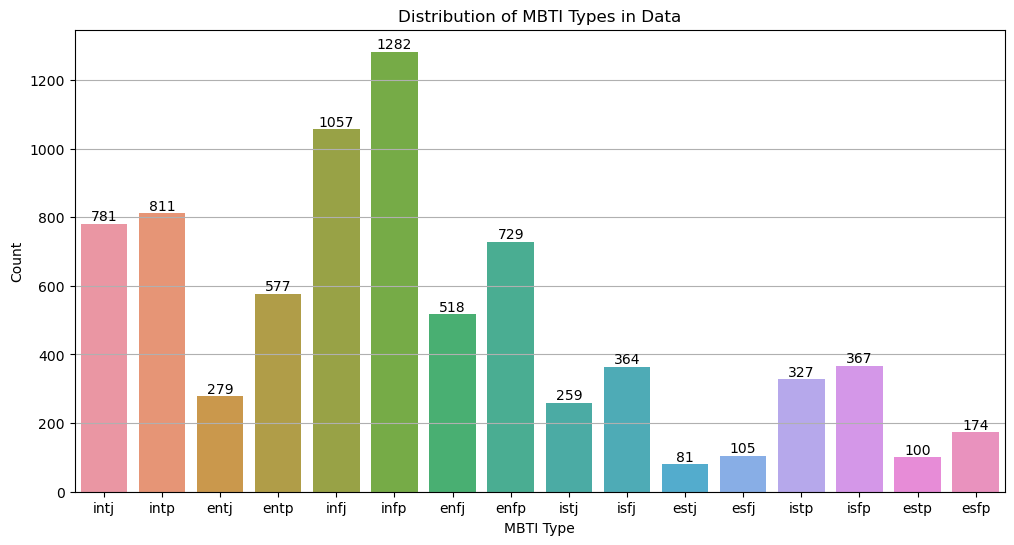

In [3]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=data)
plt.xlabel('MBTI Type')
plt.ylabel('Count')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0, 
        height,
        f'{int(height)}',
        ha='center', 
        va='bottom'
    )
    
plt.title('Distribution of MBTI Types in Data')
ax.yaxis.grid()
plt.show()

C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Words in Tweets'}, xlabel='Number of Words in Tweet', ylabel='Count'>

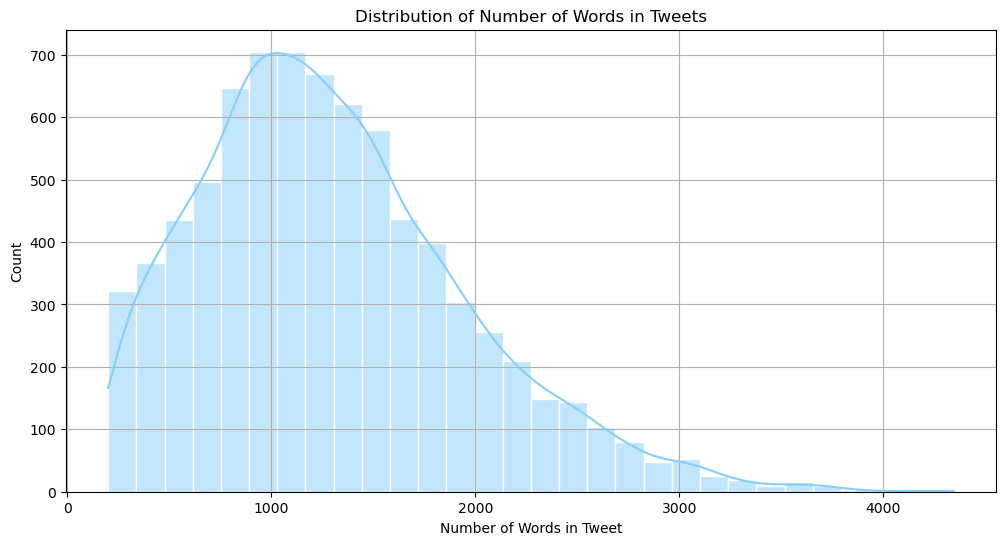

In [4]:
data['number words'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.grid()
plt.xlabel('Number of Words in Tweet')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Tweets')

sns.histplot(data=data['number words'], bins=30, kde=True, color='lightskyblue', ec='w')

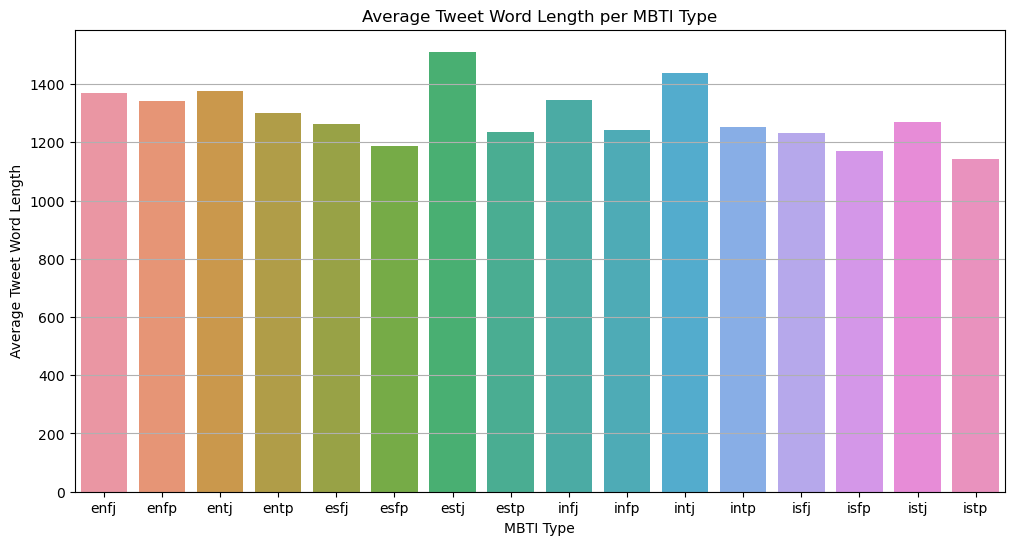

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

twt_len_by_mbti = data.groupby('label')['number words'].mean()
sns.barplot(x=twt_len_by_mbti.index, y=twt_len_by_mbti)
plt.xlabel('MBTI Type')
plt.ylabel('Average Tweet Word Length')
plt.title('Average Tweet Word Length per MBTI Type')
ax.yaxis.grid()

plt.show()

In [6]:
char_counts = defaultdict(int)

def count_characters(text):
    words = text.split(' ')
    
    for word in words:
        for character in word:
            character = character.lower()
            
            if character.isalpha() and character.isascii():
                char_counts[character] += 1
            else:
                char_counts['Other'] += 1

data['text'].apply(count_characters)

0       None
1       None
2       None
3       None
4       None
        ... 
7806    None
7807    None
7808    None
7809    None
7810    None
Name: text, Length: 7811, dtype: object

C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


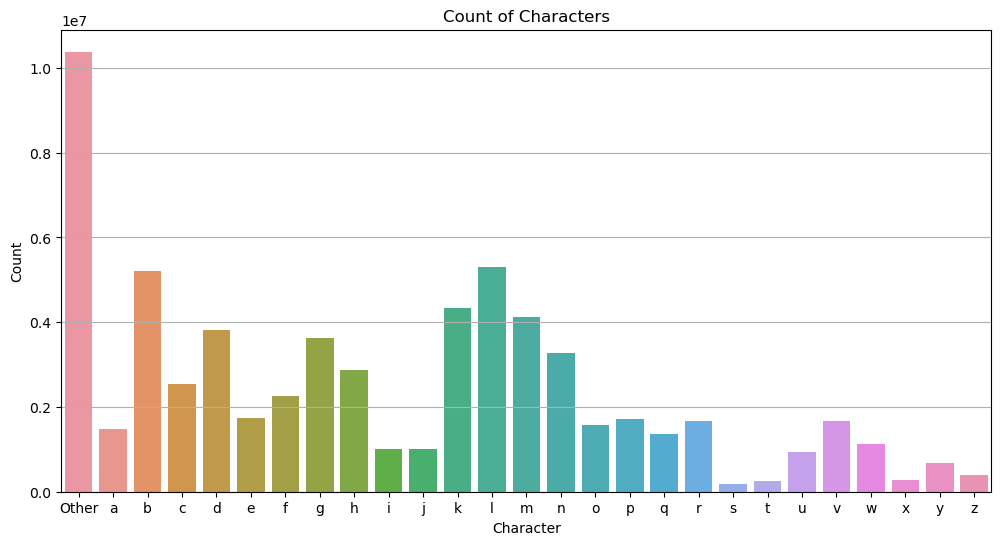

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=sorted(list(char_counts)), y=list(char_counts.values()))
plt.xlabel('Character')
plt.ylabel('Count')
plt.title('Count of Characters')
ax.yaxis.grid(True)

plt.show()

In [8]:
MBTI_types = data['label'].unique()

def find_most_common_words(MBTI_type, n=10):
    all_words = ' '.join(data[data['label'] == MBTI_type]['text'])
    words = [word for word in all_words.split() if word.lower() not in ENGLISH_STOP_WORDS]
    common_words = Counter(words).most_common(n)
    return common_words

In [9]:
all_words = []

for i, MBTI in enumerate(MBTI_types):
    common = find_most_common_words(MBTI)
    words = [tup[0] for tup in common]
    all_words += words

all_words = list(set(all_words))

colors = sns.color_palette("hls", len(all_words))
color_dict = {}

for i in range(len(all_words)):
    color_dict[all_words[i]] = colors[i]

C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\a

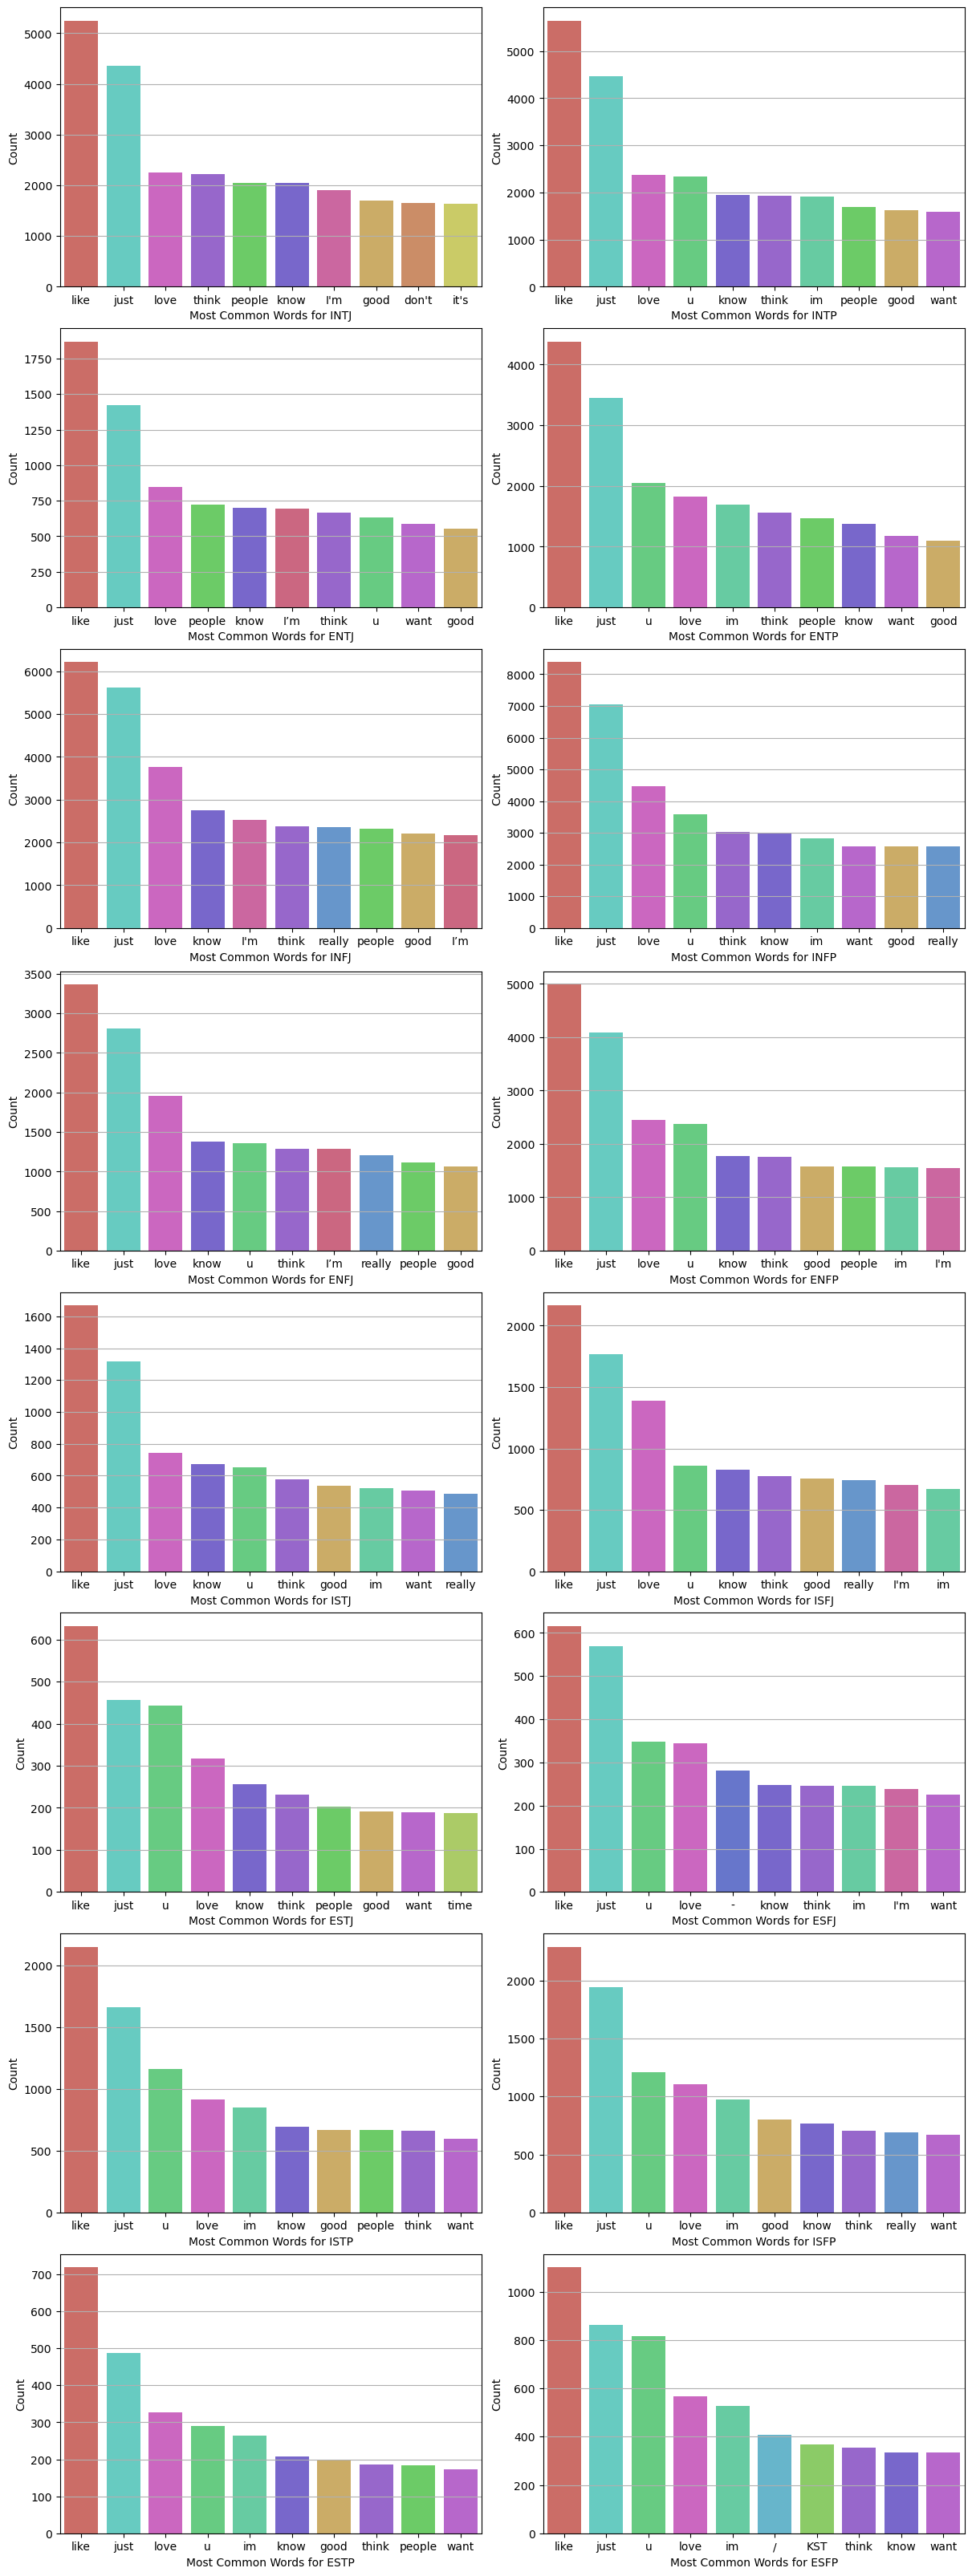

In [10]:
num_cols = 2
num_rows = (len(MBTI_types) + num_cols - 1) // num_cols 
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()


for i, MBTI in enumerate(MBTI_types):
    common = find_most_common_words(MBTI)
    words = [tup[0] for tup in common]
    colors = [color_dict[word] for word in words]
    counts = [tup[1] for tup in common]
    
    sns.barplot(x=words, y=counts, ax=axes[i], palette=colors)
    axes[i].set_xlabel(f'Most Common Words for {MBTI.upper()}')
    axes[i].set_ylabel('Count')
    axes[i].yaxis.grid()
    
plt.show()